# Prediction

In this stage, we'll take our cleaned dataset and experiment with different models to predict if a loan will default.

## Train-test split and normalization

We split our data into a train set and a test set, then normalise each set independently. By removing outliers in the data processing step we can be confident that the normalisation step is not being skewed by outliers. 


In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import itertools

In [2]:
random_state = 10

In [3]:
def data_from_dataset(filename = "../../data/processed/loan_sampled_50000.csv"):
    df = pd.read_csv(filename, 
                low_memory = False)
    
    y = (df["target"]).astype(int)
    X = df.drop(columns = ["target"])
    X_train_orig, X_test_orig, y_train, y_test = train_test_split(X, y, 
                                                   random_state = random_state)
    print(f"Train size: {X_train_orig.shape}\nTest size: {X_test_orig.shape}")
    return X_train_orig, X_test_orig, y_train, y_test

In [4]:
def normalize_df(df):
    scaler = MinMaxScaler()
    df = pd.DataFrame(scaler.fit_transform(df.values), 
                       columns=df.columns, index=df.index)
    return df

In [5]:
(X_train_orig, X_test_orig, y_train, y_test) = data_from_dataset("../../data/processed/loan_sampled_50000.csv")
X_train = normalize_df(X_train_orig)
X_test = normalize_df(X_test_orig)

Train size: (19103, 82)
Test size: (6368, 82)


/home/mikey/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


We notice that there is a class imbalance in our training set, as with our orginal dataset. While this does likely reflect the business context - it is more likely that a loan will not be defaulted on - we want to ensure that our models are not biased by way of the training data containing more examples of one class. 

We can take two resampling approaches to deal with this class imbalance problem:

- Oversampling the minority class

- Undersampling the majority class

There is a good discussion of approaches here: https://www.kaggle.com/rafjaa/resampling-strategies-for-imbalanced-datasets. For simplicity, I will run the models on two datasets: the original training data, and an undersampled dataset (created by randomly removing instances of the majority class until the dataset is balanced. 

In [6]:
def undersample_dataset(X_train_orig, y_train):
    df_train = pd.concat([X_train_orig, y_train], axis = 1)
    count_class_0, count_class_1 = df_train.target.value_counts()
    df_class_0 = df_train[df_train['target'] == 0]
    df_class_1 = df_train[df_train['target'] == 1]
    df_class_0_under = df_class_0.sample(count_class_1)
    df_test_under = pd.concat([df_class_0_under, df_class_1], axis=0)

    print(df_test_under.target.value_counts())
    X_train_under = df_test_under.drop(columns=["target"])
    y_train_under = df_test_under["target"].astype(int)

    scaler = MinMaxScaler()
    X_train_under = pd.DataFrame(scaler.fit_transform(X_train_under.values), 
                           columns=X_train_under.columns, index=X_train_under.index)
    return X_train, y_train

In [7]:
y_train.value_counts()

0    15011
1     4092
Name: target, dtype: int64

In [8]:
(X_train_under, y_train_under) = undersample_dataset(X_train_orig, y_train)

1    4092
0    4092
Name: target, dtype: int64


/home/mikey/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


## Model testing

We're going to try the following models:

- Logistic regression

- Decision trees

- Naive Bayes

- Random forest


To evaluate our models, we'll consider the following metrics:

- Confusion matrix

- Accuracy, precision, and recall

- ROC and AUC 

In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_fscore_support

In [10]:
def plot_cm(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    
def calc_metrics(conf_mat):
    tn, fp, fn, tp = conf_mat.ravel()
    accuracy = (tp + tn) / (tn + fp + fn + tp)
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    return {'accuracy': accuracy, 'precision': precision, 'recall': recall}

def print_metrics(metric_dict):
    for k, v in metric_dict.items():
        print(f"{k}: {v:.2f}")
        
def compare_models(X_train, X_test, y_train, y_test):
    results = []
    metrics_dict = {}
    labels = ["Random guess", "Logistic Regression", "Decision Tree", "Random Forest", "Gaussian"]

    logret = LogisticRegression()
    dt = DecisionTreeClassifier()
    # TODO tune model
    randomforest = RandomForestClassifier()
    gauss = GaussianNB()
    models = [None, logret, dt, randomforest, gauss]

    for i in range(1, len(models)):
        model = models[i]

        model.fit(X_train, y_train)
        y_preds = model.predict(X_test)
        y_preds_probs = model.predict_proba(X_test)

        (fpr, tpr, thresholds) = roc_curve(y_test, y_preds_probs[:, 1])
        auc = roc_auc_score(y_test, y_preds_probs[:, 1])
        results.append((fpr, tpr, auc))
        # We want 'default' to be true positive
        conf_mat = confusion_matrix(y_test, y_preds, [1, 0])
        print(f"Model name: {labels[i]}")
        print(f"AUC      : {auc:.2f}")
        metrics = calc_metrics(conf_mat)
        print(f"Accuracy : {metrics['accuracy']:.2f}")
        print(f"Precision: {metrics['precision']:.2f}")
        print(f"Recall   : {metrics['recall']:.2f}")
        print(f"Confusion matrix: \n{conf_mat}")
    
        metrics_dict[labels[i]] = [auc, metrics['accuracy'], metrics['precision'], metrics['recall']]
    # Plot ROC curve
    fig, ax = plt.subplots(figsize = (10, 10))
    ax.plot([0, 1], [0, 1], '--k', lw = 1)
    for res in results:
        ax.plot(res[0], res[1])
    ax.legend(labels, loc = 4)
    plt.show()
    
    return metrics_dict

### Imbalanced dataset

Model name: Logistic Regression
AUC      : 0.71
Accuracy : 0.78
Precision: 0.82
Recall   : 0.93
Confusion matrix: 
[[ 295 1052]
 [ 328 4693]]
Model name: Decision Tree
AUC      : 0.55
Accuracy : 0.63
Precision: 0.81
Recall   : 0.68
Confusion matrix: 
[[ 563  784]
 [1585 3436]]
Model name: Random Forest
AUC      : 0.64
Accuracy : 0.77
Precision: 0.81
Recall   : 0.92
Confusion matrix: 
[[ 236 1111]
 [ 382 4639]]
Model name: Gaussian
AUC      : 0.65
Accuracy : 0.73
Precision: 0.82
Recall   : 0.83
Confusion matrix: 
[[ 444  903]
 [ 836 4185]]


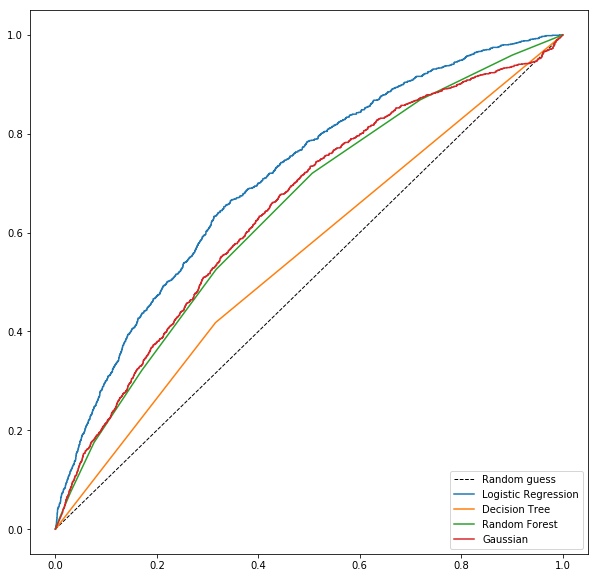

In [11]:
metrics_dict_imbalanced = compare_models(X_train, X_test, y_train, y_test)

### Balanced dataset

Model name: Logistic Regression
AUC      : 0.71
Accuracy : 0.78
Precision: 0.82
Recall   : 0.93
Confusion matrix: 
[[ 295 1052]
 [ 328 4693]]
Model name: Decision Tree
AUC      : 0.55
Accuracy : 0.63
Precision: 0.81
Recall   : 0.69
Confusion matrix: 
[[ 555  792]
 [1566 3455]]
Model name: Random Forest
AUC      : 0.64
Accuracy : 0.76
Precision: 0.81
Recall   : 0.91
Confusion matrix: 
[[ 256 1091]
 [ 447 4574]]
Model name: Gaussian
AUC      : 0.65
Accuracy : 0.73
Precision: 0.82
Recall   : 0.83
Confusion matrix: 
[[ 444  903]
 [ 836 4185]]


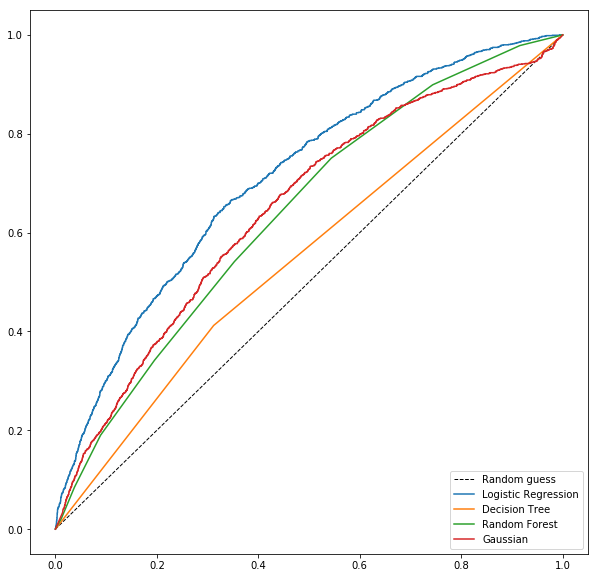

In [12]:
metrics_dict_balanced = compare_models(X_train_under, X_test, y_train, y_test)

### Full dataset

We'll try now testing the algorithms on the full dataset. Note that we actually lose around half the dataset because we've been rather ruthless 

In [14]:
(X_train_orig, X_test_orig, y_train, y_test) = data_from_dataset("../../data/processed/loan.csv")

Train size: (863134, 82)
Test size: (287712, 82)


In [15]:
X_train_orig.isnull().values.ravel().sum()

0

In [16]:
X_test_orig.isnull().values.ravel().sum()

1

In [20]:
X_test_orig.fillna(0, inplace = True)

In [21]:
X_train = normalize_df(X_train_orig)
X_test = normalize_df(X_test_orig)

/home/mikey/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


Model name: Logistic Regression
AUC      : 0.72
Accuracy : 0.79
Precision: 0.80
Recall   : 0.98
Confusion matrix: 
[[  5891  56788]
 [  4422 220611]]
Model name: Decision Tree
AUC      : 0.54
Accuracy : 0.59
Precision: 0.80
Recall   : 0.63
Confusion matrix: 
[[ 27556  35123]
 [ 82222 142811]]
Model name: Random Forest
AUC      : 0.63
Accuracy : 0.75
Precision: 0.80
Recall   : 0.90
Confusion matrix: 
[[ 12207  50472]
 [ 21450 203583]]
Model name: Gaussian
AUC      : 0.67
Accuracy : 0.73
Precision: 0.81
Recall   : 0.84
Confusion matrix: 
[[ 19031  43648]
 [ 35155 189878]]


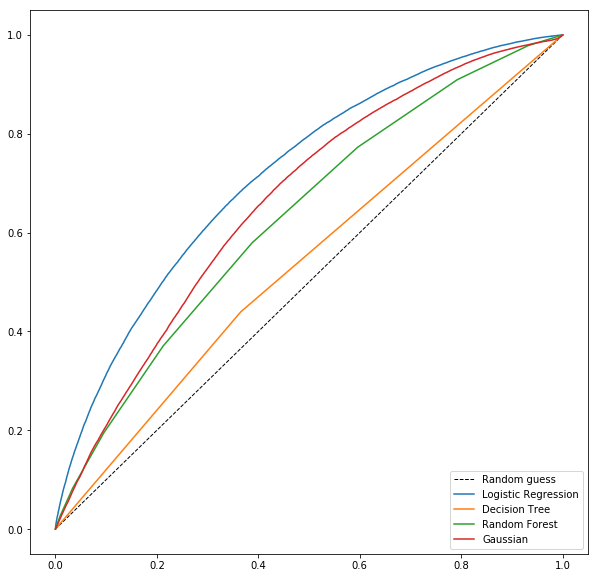

In [22]:
metrics_dict_all = compare_models(X_train, X_test, y_train, y_test)